## Ablation study

If a group of filters are almost identical in the cosine-similarity sense, then can we replace that group by a single filter? And how does this affect the network outputs?




### Filter similarity matrix

We load in a pre-trained network (see the Notebook `run_cifar_train_mlp`) and compute the simlarity matrix of its first layer "filters" -- for a fully-connected network this would correspond to the 3072-dimensional column-vectors of the weight matrix of the first layer.

In [1]:
# setup
import os
import torch
import torchvision
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
# local utils
# !find . -name \*.pyc -delete
from vis_utils import *
from model_def import *
from model_train import *

%matplotlib inline


expName = 'cifar-MLP_v6.0.5' # pre-trained MLP - w1:500, w2:100
batchSize = 100

# create experiment folder
expDir = os.path.join('./data', expName)
if not os.path.exists(expDir):
    os.makedirs(expDir)
    
# setup and load CIFAR dataset
trainloader, testloader, classes = setup_cifar_data_mlp(batchSize)

Files already downloaded and verified
Files already downloaded and verified


In [2]:
def get_dataset_loss(net, dataloader, criterion = nn.CrossEntropyLoss()):
    '''
        Calculate the network loss over a dataset.
        Returns a vector containing the loss for every data point.
    '''
    
    data_loss = []    
    useGpu = next(net.parameters()).is_cuda
    
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data
        if useGpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        outputs = net(inputs)
        loss = criterion(outputs, labels)  
        data_loss.append(loss.data.cpu())
        
    data_loss = [x.numpy()[0] for x in data_loss]    
    return data_loss

In [42]:
# create the fully-connected network with ReLU non-linearities
net = MLP(input_dim=3072, fc1_dim=500, fc2_dim=100)

# Load trained MLP model and look at closest pairs of filters
net.load_state_dict(torch.load(os.path.join(expDir, 'net-trained.dat')))

net.cpu()

MLP (
  (fc1): Linear (3072 -> 500)
  (fc2): Linear (500 -> 100)
  (fc3): Linear (100 -> 10)
)

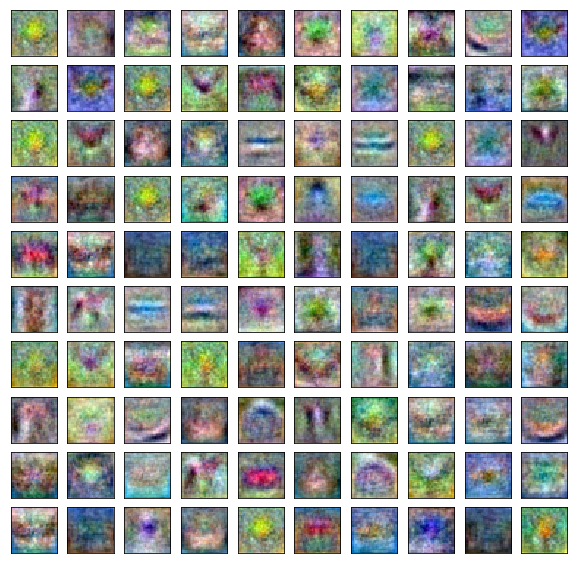

In [43]:
# Get similarity matrix
similMat, w = get_layer_cosine_similarity(net.cpu(), 'fc1.weight')
MAX_PAIRS = 10
outDir = expDir

# show the filter pairs
# _, pairList = vis_closest_filter_pairs(w, similMat, MAX_PAIRS)       

f = vis_linear_weights(w)


In [117]:
# evaluate the original network
# -- should be 53%
net.eval()
orig_accu = accuracy_on_dataset(net, testloader, True)
print 'Original network accuracy: %.2f' % orig_accu

orig_data_loss = get_dataset_loss(net, testloader)
print 'Original network data loss: %.4f' % np.mean(orig_data_loss)

Original network accuracy: 53.00
Original network data loss: 1.3616


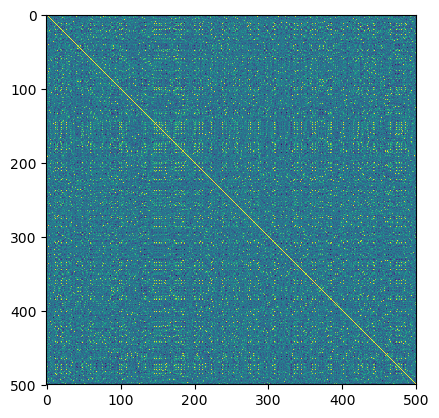

In [118]:
f = plt.figure()
plt.imshow(similMat) # show similarity matrix
plt.savefig(os.path.join(expDir,'mlp-w1-simil.png'), bbox_inches='tight')

### Connected components of similar filters




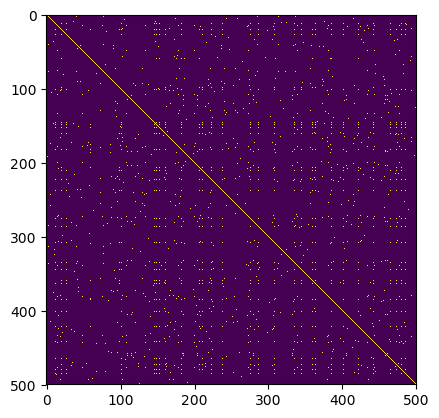

In [55]:
# Get an adjancency matrix by thresholding the similarity matrix
SIMIL_THRESH = 0.8
sz = similMat.shape
adj_mat = np.greater(similMat, SIMIL_THRESH)

f = plt.figure()
plt.imshow(adj_mat)  # show adjacency matrix
plt.savefig(os.path.join(expDir,'mlp-w1-adj-mat-%.2f.png' % SIMIL_THRESH), bbox_inches='tight')

In [56]:
# Find connected components in the graph induced by the adjacency matrix
from scipy.sparse import *
n_comps, comp_labels = csgraph.connected_components(adj_mat, directed=False)
cc_set = np.unique(comp_labels)

In [57]:

# init a list of lists
cc_list = []
for i in range(len(cc_set)):
    cc_list.append([])

# cc_list[i] stores the indices (j) of the filters in the i-th conn-comp
for i in range(len(cc_set)):
    for j in range(sz[0]):
        if comp_labels[j] == cc_set[i]:
            cc_list[i].append(j)

print n_comps

178


In [58]:
# Group the filters in each connected component (cc)
outDir = os.path.join(expDir, ('filter_ccomp_%.2f' % SIMIL_THRESH))
if not os.path.exists(outDir):
    os.makedirs(outDir)
    
# Get the filters in a CPU numpy array    
fc1_weights = net.fc1.weight.data.cpu()
fc1_weights = fc1_weights.numpy()

# Get the bias values for each filter
fc1_biases = net.fc1.bias.data.cpu()
fc1_biases = fc1_biases.numpy()

bias_val = [fc1_biases[x] for x in cc_list]


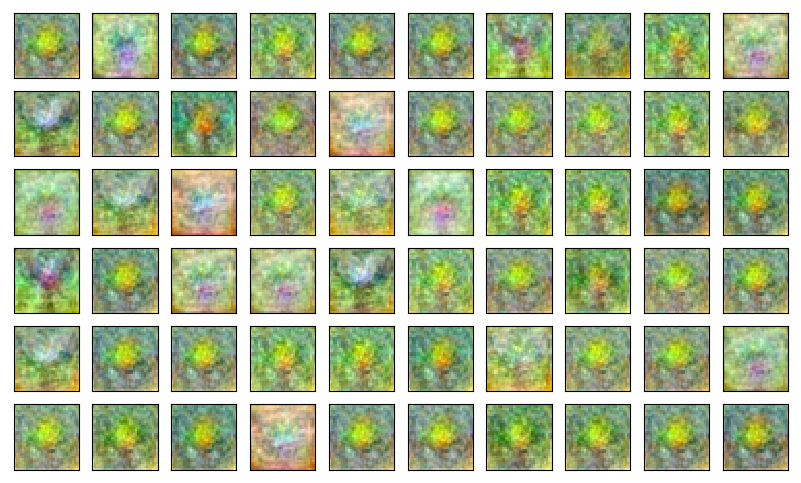

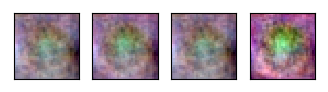

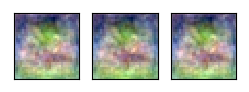

In [59]:
# Some sanity-checks: visualize some of the filter groups
f = vis_linear_weights(fc1_weights[cc_list[0]]) 
f = vis_linear_weights(fc1_weights[cc_list[1]])
f = vis_linear_weights(fc1_weights[cc_list[2]]) 

In [10]:
# Print out the biases for those same filter groups
print fc1_biases[cc_list[0]]
print fc1_biases[cc_list[1]]
print fc1_biases[cc_list[2]]

[ 0.01790267  0.06339222  0.04900303  0.01225822  0.01943754  0.08872543
  0.01694     0.03938906  0.00921285  0.0087124   0.02052768  0.02965015
  0.07969613  0.00534704  0.00994039  0.09928659  0.02670029  0.00977978
  0.01786249  0.00900509  0.0490663   0.02609462  0.01402789  0.01722807
  0.0275471   0.02839933  0.02669318  0.0140364   0.06810491  0.05025906
  0.01464979  0.01108932  0.00769131  0.02536192  0.00802891  0.02085854
  0.00834615  0.01303058  0.00894189  0.01784183  0.01147795]
[ 0.01260188  0.00685998  0.0092797 ]
[ 0.00225052  0.00770126  0.01382509]


In [13]:
# Print out the norms of the filters in the filter groups
print [ np.linalg.norm(w) for w in fc1_weights[cc_list[0]] ]
print [ np.linalg.norm(w) for w in fc1_weights[cc_list[1]] ]
print [ np.linalg.norm(w) for w in fc1_weights[cc_list[2]] ]

[0.045579161, 0.18611306, 0.032723535, 0.048916616, 0.044610474, 0.023154335, 0.049587313, 0.02920825, 0.023913147, 0.06488324, 0.066258013, 0.075001858, 0.067560554, 0.034925897, 0.02714261, 0.018804545, 0.021381082, 0.054155864, 0.025560828, 0.045993179, 0.034088094]
[0.12358262, 0.10077423]
[0.021809677, 0.072956905, 0.13872513]


KeyboardInterrupt: 

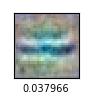

In [15]:
# Plot the filters in each filter group and save the figures to file
w = fc1_weights
for i in range(len(cc_list)):
        
    plt.rcParams["figure.figsize"] = (10, 10) # (width, height)
    f = plt.figure()
    subplotCounter = 1
    
    K = np.min([len(cc_list[i]), 100])
    
    # plot the filters in each filter conn_comp
    for j in range(K):
        w1 = w[cc_list[i][j]]
        w1 = w1.reshape(3, 32, 32)
        w1 = np.transpose(w1, (1,2,0))
        low, high = np.min(w1), np.max(w1)
        im1 = 255.0 * (w1 - low) / (high - low)
        
        ax = f.add_subplot(10, 10, subplotCounter)
        ax.imshow(im1.astype('uint8'))
        subplotCounter += 1
        ax.set_xticks([]); ax.set_yticks([]); ax.set_xticklabels([]); ax.set_yticklabels([])
        ax.set_xlabel('%.6f' % bias_val[i][j], fontsize=7)
     
    f.savefig(os.path.join(outDir, ('%d-1.png' % i)), \
             bbox_inches='tight')
    plt.close(f)
    plt.rcParams.update(plt.rcParamsDefault)

#### Distribution of filter group sizes

We observe that very large filter groups are not common -- most connected components being of sizes between 1 to 4. There are a few large groups of redundant filters. A component of size one would be a singleton filter group that is sufficiently dissimilar to all other filters in its layer.

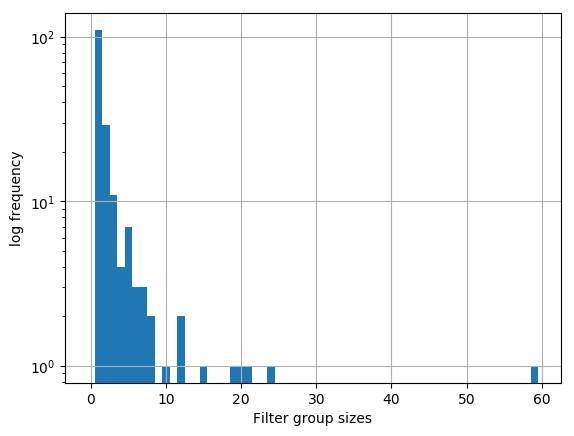

In [60]:
# Distribution of filter-cc sizes
cc_sizes = [len(x) for x in cc_list]
f = plt.figure()
plt.rcParams.update(plt.rcParamsDefault)
plt.hist(cc_sizes, bins=range(np.max(cc_sizes)+1), align='left', log=True);
# plt.xticks(range(np.max(cc_sizes)));
plt.grid(); plt.xlabel('Filter group sizes'); plt.ylabel('log frequency')
f.savefig(os.path.join(expDir, 'filter-group-size-hist_%.2f.png' % SIMIL_THRESH), \
          bbox_inches='tight')

#### Norms of weights in a filter group

The filters in a connected component or "filter group" are similar based on the cosine of the angles between their weight vectors. Although they may be pointing in the same _direction_, their _lengths_ may be different. This is indeed the case, as the norms of the filters within a group end up being quite different. The fact also makes the cosine similarity a better metric for filter similarity than L2-distance.

Standard Deviation of weight norms within non-singleton filter groups:


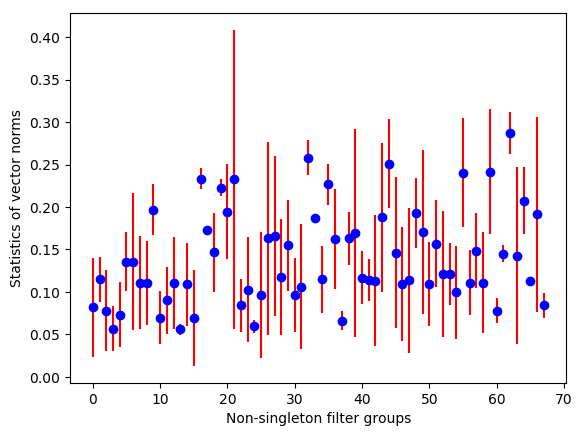

In [61]:
# The L2 norms of each weight in a filter group
group_w_norms = [ [np.linalg.norm(w) for w in fc1_weights[x]] for x in cc_list ]
w_norm_std = np.asarray([np.std(x) for x in group_w_norms])
w_norm_mean = np.asarray([np.mean(x) for x in group_w_norms])
group_non_singleton = np.where([(len(x)>1) for x in cc_list])
w_norm_std = w_norm_std[group_non_singleton]
w_norm_mean = w_norm_mean[group_non_singleton]

print 'Standard Deviation of weight norms within non-singleton filter groups:'
f = plt.figure()
plt.rcParams.update(plt.rcParamsDefault)
plt.errorbar(range(len(w_norm_mean)), w_norm_mean, yerr=w_norm_std, fmt='bo', ecolor='r')
plt.ylabel('Statistics of vector norms')
plt.xlabel('Non-singleton filter groups')
f.savefig(os.path.join(expDir, 'filter-group-norm-stats-%.2f.png' % SIMIL_THRESH), \
          bbox_inches='tight')


### Connection sparsity structure

Visualize the connection matrix from the first layer to the second -- the fc2 weights.




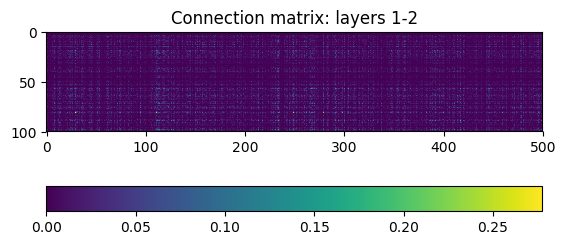

In [62]:
# plot the fc-2 weight matrix
net.cpu()
w_fc2 = np.abs(net.fc2.weight.data.numpy())  # absval
plt.imshow(w_fc2)
plt.title('Connection matrix: layers 1-2')
plt.colorbar(orientation='horizontal')

In [63]:
w_fc2.shape

(100, 500)

[]

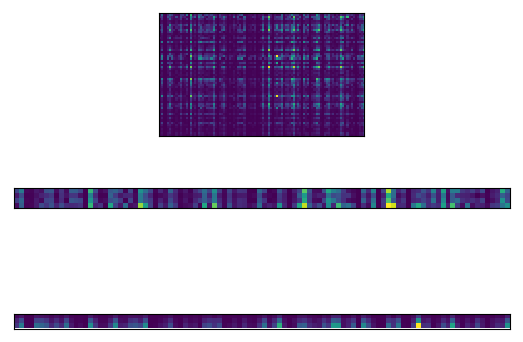

In [64]:
# visualize connection matrices for some filter groups

f = plt.figure()
plt.subplots_adjust(hspace=0.0001)

ax = f.add_subplot(3, 1, 1)
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticklabels([])
ax.set_yticks([])
ax.imshow(np.transpose(w_fc2[:,cc_list[0]]))

ax = f.add_subplot(3, 1, 2)
ax.imshow(np.transpose(w_fc2[:,cc_list[1]]))
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticklabels([])
ax.set_yticks([])

ax = f.add_subplot(3,1, 3)
ax.imshow(np.transpose(w_fc2[:,cc_list[2]]))
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticklabels([])
ax.set_yticks([])


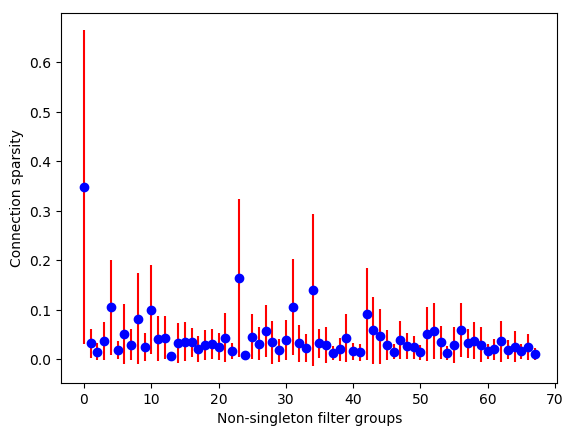

In [65]:
# Summary stats of fc2-layer L1-norms of all non-singleton filter groups

fc2_w_norms = [ [np.linalg.norm(w,ord=1) for w in w_fc2[:,x]] for x in cc_list ]
fc2_w_norm_std = np.asarray([np.std(x) for x in fc2_w_norms])
fc2_w_norm_mean = np.asarray([np.mean(x) for x in fc2_w_norms])
group_non_singleton = np.where([(len(x)>1) for x in cc_list])

fc2_w_norm_std = fc2_w_norm_std[group_non_singleton]
fc2_w_norm_mean = fc2_w_norm_mean[group_non_singleton]

# plot
f = plt.figure()
plt.rcParams.update(plt.rcParamsDefault)
plt.errorbar(range(len(fc2_w_norm_mean)), fc2_w_norm_mean, yerr=fc2_w_norm_std, fmt='bo', ecolor='r')
plt.ylabel('Connection sparsity')
plt.xlabel('Non-singleton filter groups')
f.savefig(os.path.join(expDir, 'filter-group-fc2-sparsity-stats-%.2f.png' % SIMIL_THRESH), \
          bbox_inches='tight')

### Equivalence-preserving weight normalization

We normalize each *fc1* layer filter (a row of first layer weight matrix *W*) by its L2-norm and then scale the corresponding connections to the fc2 layer (a column of second layer weight matrix *V*).

Let us assume a non-linearity of the form $$ \phi(a \mathbf x) = a \phi(\mathbf x) $$
This holds true for the commonly used ReLU activation function in the positive domain.

Then, for one row of the first layer's weight matrix and bias term and _one_ connection to the next layer, we have,

$$ y_1 = v_1 . \phi(\mathbf{w}_1 \mathbf x + b_1) 
       = v_1 . \phi(||\mathbf{w}_1|| \frac{\mathbf{w}_1}{||\mathbf{w}_1||} \mathbf x + ||\mathbf{w}_1|| \frac{b_1}{||\mathbf{w}_1||}) 
       = ||\mathbf{w}_1|| . v_1 . \phi(\tilde{\mathbf{w}}_1 \mathbf x + \tilde b_1) $$


This normalization of fc1 weights should keep the function computed by the network exactly the same as before.

In [66]:
# Unchanged network
net = MLP(input_dim=3072, fc1_dim=500, fc2_dim=100)
net.load_state_dict(torch.load(os.path.join(expDir, 'net-trained.dat')))
net.cpu()
orig_data_loss = get_dataset_loss(net, testloader)
np.mean(orig_data_loss)


1.3616375

#### Parameter scaling

In [67]:
# Scale the fc1 filter weights and the biases by the inverse of the filter norms
w_n = [torch.norm(w,p=2) for w in net.fc1.weight] 
w_normed = [w.div(w_n[index]) for index, w in enumerate(net.fc1.weight)] 
w_normed = torch.stack(w_normed, dim=0)
b_normed = torch.stack([b.div(w_n[index]) for index, b in enumerate(net.fc1.bias)]).squeeze()

print type(w_normed) 
print type(b_normed)

<class 'torch.autograd.variable.Variable'>
<class 'torch.autograd.variable.Variable'>


In [68]:
# Scale the fc2 weight columns to account for the changed fc1 layer parameter values
fc2_sc = []
for i in range(net.fc2.weight.size()[1]):
    fc2_sc.append( net.fc2.weight[:,i] * w_n[i] )
fc2_sc = torch.stack(fc2_sc, dim=1)


In [69]:
# Wrap by nn.Parameter
net.fc1.weight = nn.Parameter(w_normed.data)
net.fc1.bias = nn.Parameter(b_normed.data)
net.fc2.weight = nn.Parameter(fc2_sc.data)


In [70]:
# Run the modified network
new_data_loss = get_dataset_loss(net, testloader)
print np.mean(new_data_loss)

new_data_loss = np.asarray(new_data_loss)
orig_data_loss = np.asarray(orig_data_loss)


1.36164


#### Verify functional equivalence

We compare the data losses on a set of inputs for the original network and the modified (scaled) network. The figures below bear out the fact that the network outputs are unchanged upto machine epsilon for floats.

Machine epsilon for float:
1.19209e-07


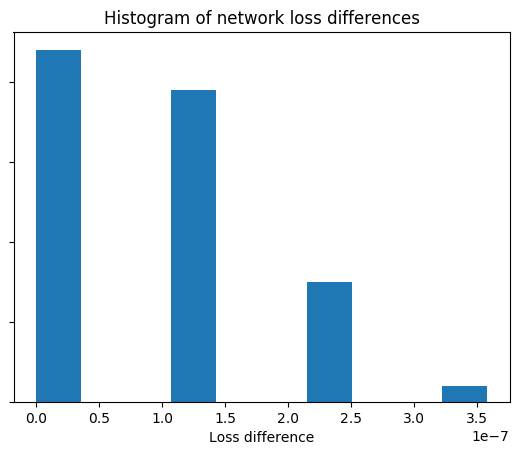

In [23]:
# Absolute differences of the loss values of the original and the modified nets
plt.rcParams.update(plt.rcParamsDefault)
net_diff = np.absolute(new_data_loss - orig_data_loss)

f = plt.figure()
ax = plt.gca()
ax.hist(net_diff);
ax.set_xlabel('Loss difference')
ax.set_title('Histogram of network loss differences')
ax.set_yticklabels([])

print 'Machine epsilon for float:'
print(np.finfo(np.float32).eps)
# TODO - fig,ax
# ax.set_yticklabels....

[]

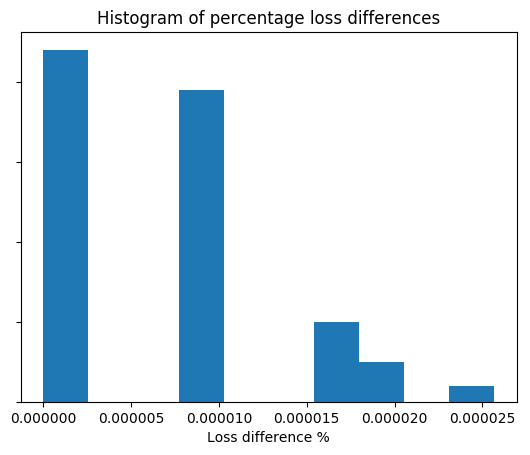

In [24]:
# Percentage difference between the network losses
plt.rcParams.update(plt.rcParamsDefault)
net_diff_percent = np.divide(net_diff, orig_data_loss) * 100
plt.hist(net_diff_percent);
plt.title('Histogram of percentage loss differences')
plt.xlabel('Loss difference %')
ax = plt.gca()
ax.set_yticklabels([])


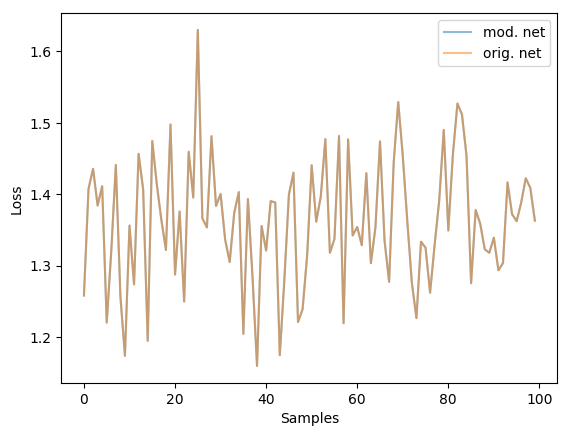

In [31]:
# Sanity check: plot the two network data losses at 100 points. 
# There should be near-perfect overlap!
plt.rcParams.update(plt.rcParamsDefault)
plt.plot(range(len(new_data_loss)), new_data_loss, alpha=0.5, label='mod. net')
plt.plot(range(len(orig_data_loss)), orig_data_loss, alpha=0.5, label='orig. net')
plt.xlabel('Samples')
plt.ylabel('Loss')
plt.legend()

In [71]:
# Evaluate the performance of reduced network
#  test: 53%
#  train: 56%
net.eval()
abl_accu = accuracy_on_dataset(net, testloader, True)
print 'Modified network test accuracy: %.2f' % abl_accu

abl_accu = accuracy_on_dataset(net, trainloader, True)
print 'Modified network train accuracy: %.2f' % abl_accu

Modified network test accuracy: 53.00
Modified network train accuracy: 56.00


### Replace near-duplicate normalized filters

Following unit-normalization of the filters, we go through the groups of near-identical (in cosine sense) filters and replace all filters in a group with the within-group mean filter. The connections to the next layer (fc2) are suitably modified as fc1 filters are removed. This should also not result in any large changes to the network function, depending upon _how close the within-group filter vectors were_ and the _conditioning of weight matrices_ that will govern the amplification or attenuation of signal propagation through the subsequent layers of the network.


#### Condition for modifying filter values

For our two-layer fully-connected network, let the output of the second layer (fc2) be

$$ \mathbf{z} =  V \mathbf{y}  =  V \phi( W\mathbf{x} + \mathbf{b} ) $$

Replacing all the near-duplicate filters with their means in **W** amounts to a small perturbation in the input, **y**, to the subsequent layer. We can then focus only on the linear system **z = Vy**. A small perturbation in **y** will not end up being magnified downstream in the network if the **V** matrix does not amplify its input signal by much. 

This possible signal amplification of the output **z**, which can be characteriszed by its 2-norm, is upper-bounded by the _maximum singular value_ of the weight matrix **V**:

$$ ||\mathbf{z}|| \le \sigma_{max} ||\mathbf{y}||  $$

The two non-linearities used in this network, ReLU and the sigmoid, are both norm-reducing operations - the ReLU gets rid of negatives and is linear otherwise, thus this cannot amplify the input. The sigmoid is a squashing function and will not amplify its inputs.



In [72]:
import scipy
import scipy.linalg

net.cpu()
w1 = net.fc1.weight.data
w1 = w1.numpy()
w2 = net.fc2.weight.data
w2 = w2.numpy()
sigma_w1 = scipy.linalg.svdvals(w1)
sigma_w2 = scipy.linalg.svdvals(w2)

print 'Max singular value of fc2: %f' % sigma_w2[0]

Max singular value of fc2: 0.549326


#### Sanity check: make similar filter pairs identical

As a sanity check, we take the top 50 similar filter pairs and make the two filters exactly equal.

In [73]:
# Sanity-check: get 50 pairs of fc1 filters and merge them
MAX_PAIRS = 50
net.cpu()
fc1Params = list(net.fc1.parameters())
w = fc1Params[0].data.numpy()

similMat, _ = get_layer_cosine_similarity(net, 'fc1.weight')
f, pairList = vis_closest_filter_pairs(w, similMat, MAX_PAIRS); 
plt.close()

print 'Similar filter pair: '
print w[pairList[0][1]]
print w[pairList[0][2]]

# make pairs identical
for j in range(MAX_PAIRS):
    listItem = pairList[j] # (similarity, rowId, colId)
    w[listItem[1]] = w[listItem[2]]
    
# check values again
print 'After duplicating pairs: '
print w[pairList[0][1]]
print w[pairList[0][2]]
    

Similar filter pair: 
[-0.05197979 -0.05227507 -0.04676607 ..., -0.01355342 -0.01328033
 -0.00744224]
[-0.05232007 -0.0526167  -0.04717456 ..., -0.01337882 -0.0131278
 -0.00742662]
After duplicating pairs: 
[-0.05232007 -0.0526167  -0.04717456 ..., -0.01337882 -0.0131278
 -0.00742662]
[-0.05232007 -0.0526167  -0.04717456 ..., -0.01337882 -0.0131278
 -0.00742662]


[]

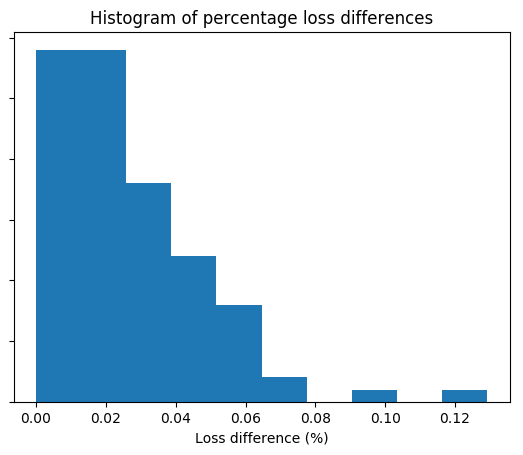

In [74]:
# Network loss value changes
new_data_loss = get_dataset_loss(net, testloader)
new_data_loss = np.asarray(new_data_loss)
net_diff = np.absolute(new_data_loss - orig_data_loss)
net_diff_percent = np.divide(net_diff, orig_data_loss) * 100
plt.hist(net_diff_percent);
plt.title('Histogram of percentage loss differences')
plt.xlabel('Loss difference (%)')
ax = plt.gca()
ax.set_yticklabels([])

#### Reduce fc1 filter groups

In this simple ablation scheme, we replace each group of similar filters by its mean filter. We do the same naive averaging for the biases as well. The size of the first layer is reduced from 500 to 399 units, due to the 399 groups of similar filters that were formed in the connected components step.

In [75]:
# Sanity checks about using nn.Parameter()
net.fc1.weight = nn.Parameter(net.fc1.weight.data)
net.fc1.bias = nn.Parameter(net.fc1.bias.data)
net.fc2.weight = nn.Parameter(net.fc2.weight.data)

# Check the network accuracy
net.eval()
net.cuda()
abl_accu = accuracy_on_dataset(net, testloader, True)
print 'Network accuracy: %.2f%%' % abl_accu

Network accuracy: 53.00%


In [76]:
# transfer network to CPU if on GPU
if next(net.parameters()).is_cuda:
    net.cpu()


In [77]:
# FC1 reduction

assert(not next(net.parameters()).is_cuda) # everything is on CPU

# Reduce FC-2 layer weights - sum
fc2_groups = [net.fc2.weight[:,x] for x in cc_list]
fc2_reduced = [x.sum(dim=1) for x in fc2_groups]
fc2_filter_cat = torch.stack(fc2_reduced, dim=0)
fc2_filter_cat = fc2_filter_cat.t()

# Reduce FC-1 layer biases - mean
fc1_bias_groups = [net.fc1.bias[torch.LongTensor(x)] for x in cc_list]
fc1_bias_reduced = [x.mean() for x in fc1_bias_groups]
fc1_bias_cat = torch.cat(fc1_bias_reduced, dim=0)
fc1_bias_cat.squeeze_()

# Reduce FC-1 layer filters - mean
fc1_filter_groups = [net.fc1.weight[torch.LongTensor(x)] for x in cc_list]
fc1_filter_reduced = [x.mean(dim=0) for x in fc1_filter_groups]
fc1_filter_cat = torch.stack(fc1_filter_reduced, dim=0)

# Wrap by nn.Parameter
net.fc1.weight = nn.Parameter(fc1_filter_cat.data)
net.fc1.bias = nn.Parameter(fc1_bias_cat.data)
net.fc2.weight = nn.Parameter(fc2_filter_cat.data)


In [78]:
# Evaluate reduced network's accuracy
net.eval()
abl_accu = accuracy_on_dataset(net, testloader, True)
print 'Reduced network accuracy: %.2f %%' % abl_accu

Reduced network accuracy: 51.00 %


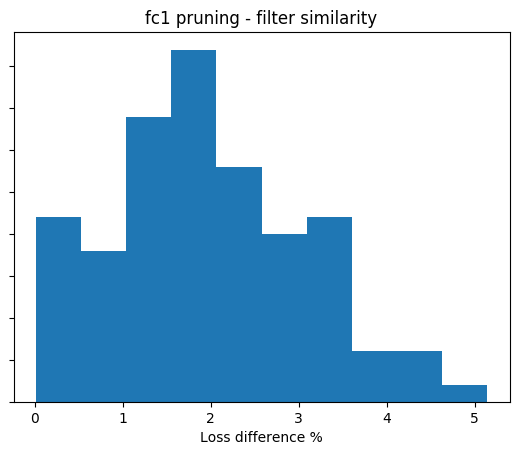

In [79]:
# Network loss value changes
new_data_loss = get_dataset_loss(net, testloader)
new_data_loss = np.asarray(new_data_loss)
net_diff = np.absolute(new_data_loss - orig_data_loss)
net_diff_percent = np.divide(net_diff, orig_data_loss) * 100
plt.hist(net_diff_percent);
plt.title('fc1 pruning - filter similarity')
ax = plt.gca()
ax.set_yticklabels([])
plt.xlabel('Loss difference %')

In [80]:
net.fc1.weight

Parameter containing:
-3.9111e-03  1.0324e-02  8.8938e-03  ...  -1.9973e-02 -2.1824e-02 -2.6276e-02
 1.9437e-02  1.3507e-02  1.3276e-02  ...  -1.0359e-02 -1.8285e-02 -1.5070e-02
-7.8948e-03 -1.1359e-02 -1.6750e-02  ...  -6.0548e-03 -1.3147e-03  1.0101e-05
                ...                   ⋱                   ...                
-5.0177e-04  1.9757e-03  5.5865e-03  ...  -4.5611e-02 -3.4848e-02 -3.8439e-02
-1.6696e-02 -6.5015e-03 -8.8328e-03  ...   1.4459e-03 -4.3176e-03 -9.4513e-03
-1.8862e-02 -1.9985e-02 -9.4565e-03  ...  -1.0967e-02 -6.3406e-03 -3.7024e-03
[torch.cuda.FloatTensor of size 178x3072 (GPU 0)]

## Baseline: low L1 norm

One of the common methods for network filter pruning is to remove those filters that have low L1-norm. This method does not provide a clear way of combining the connections to the next layer. The filters in the fc1 layer are sorted by L1-norm and the top K are retained. The corresponding connections in fc2 are also pruned away. No weight adjustment is done.


In [81]:
# re-load the original network
net = MLP(input_dim=3072, fc1_dim=500, fc2_dim=100)
net.load_state_dict(torch.load(os.path.join(expDir, 'net-trained.dat')))

In [82]:
NUM_KEEP = 178 # (399, 270, 178) number of filters to *keep* in fc1 layer, matching number from similarity experiments

params = net.state_dict()
w_fc1 = params['fc1.weight']
w_fc1 # 500x3072 tensor


 1.7173e-04  6.5106e-04  3.9853e-04  ...  -1.8087e-04 -1.0360e-04 -2.0282e-04
 2.2925e-03  1.4488e-03  1.2393e-03  ...  -1.8523e-03 -2.7922e-03 -2.4274e-03
-7.3091e-05 -1.7227e-04 -2.9448e-04  ...  -5.0163e-05  3.2600e-05  6.6974e-05
                ...                   ⋱                   ...                
 2.7202e-03  1.9336e-03  1.0403e-03  ...   2.8684e-03  3.5034e-03  3.3303e-03
 1.1534e-03  1.3544e-04 -6.5986e-04  ...   3.2924e-03  4.0898e-03  4.6052e-03
-1.0214e-03 -3.6937e-03 -2.2959e-03  ...  -2.0747e-03 -2.6193e-03 -4.6912e-03
[torch.FloatTensor of size 500x3072]

In [83]:
w_fc1_norms = [torch.norm(w, p=1) for w in w_fc1]
sort_indices = np.argsort(w_fc1_norms)
w_fc1_norms = np.asarray(w_fc1_norms)

pruned_indices = sort_indices[-NUM_KEEP:]


In [84]:
# fc1 filter reduction
net.cpu()
fc1_filter_reduced = net.fc1.weight[torch.LongTensor(pruned_indices)]
fc1_bias_reduced = net.fc1.bias[torch.LongTensor(pruned_indices)]
fc2_reduced = net.fc2.weight[:,torch.LongTensor(pruned_indices)]


In [85]:
# Wrap by nn.Parameter
net.fc1.weight = nn.Parameter(fc1_filter_reduced.data)
net.fc1.bias = nn.Parameter(fc1_bias_reduced.data)
net.fc2.weight = nn.Parameter(fc2_reduced.data)
net.fc1.weight # 399x3072 tensor after pruning

Parameter containing:
 7.7011e-04  1.6432e-03  6.4879e-04  ...  -2.2003e-03 -2.3207e-03 -2.1881e-03
 9.6120e-04  5.6684e-04 -4.8902e-04  ...  -2.1476e-03 -1.2457e-03 -2.4650e-03
 3.9467e-03  3.1644e-03  2.3423e-03  ...   2.0134e-04 -6.6597e-04  3.8970e-04
                ...                   ⋱                   ...                
-6.1681e-03 -7.5968e-03 -9.4699e-04  ...  -9.0518e-03 -8.7284e-03 -8.1922e-03
-7.1741e-03 -6.7285e-03 -4.1238e-03  ...  -5.4632e-03 -2.2112e-03 -2.6829e-03
 7.4597e-03  3.7596e-03  5.2251e-03  ...  -6.4159e-03 -7.4041e-03 -6.7569e-03
[torch.FloatTensor of size 178x3072]

In [86]:
# Evaluate reduced network's accuracy
net.eval()
abl_accu = accuracy_on_dataset(net, testloader, True)
print 'Reduced network accuracy: %.2f %%' % abl_accu


Reduced network accuracy: 47.00 %


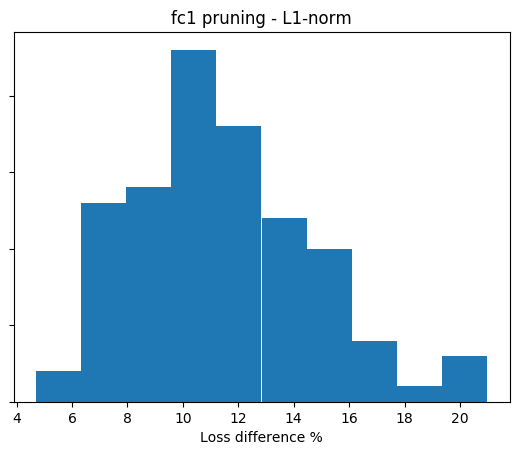

In [87]:
# Network loss value changes
new_data_loss = get_dataset_loss(net, testloader)
new_data_loss = np.asarray(new_data_loss)
net_diff = np.absolute(new_data_loss - orig_data_loss)
net_diff_percent = np.divide(net_diff, orig_data_loss) * 100

plt.hist(net_diff_percent);
plt.title('fc1 pruning - L1-norm')
ax = plt.gca()
ax.set_yticklabels([])
plt.xlabel('Loss difference %')
